# Inference on EEG data using CNN techniques

run this in your terminal window

```
pip install mne 
```

Add required dependencies and download dataset using json

In [15]:
import os
import json
import matplotlib.pyplot as plt
from mne.datasets import eegbci
import mne 
import numpy as np
import pandas as pd
import cmath

Download the file - Adjust mne_config if runnung this file locally

In [16]:
# Set MNE data directory to user's home folder
mne_config_dir = os.path.expanduser("~/.mne")
os.makedirs(mne_config_dir, exist_ok=True)


mne_data_path = os.path.expanduser("~/mne_data")
os.makedirs(mne_data_path, exist_ok=True)


mne_config = {
    "MNE_DATA": mne_data_path
}
with open(os.path.join(mne_config_dir, "mne-python.json"), "w") as f:
    json.dump(mne_config, f)

print(f"MNE_DATA directory set to: {mne_data_path}")
print("To download the EEG BCI dataset, Press 'Y' when prompted")


MNE_DATA directory set to: /Users/jpxmaestas/mne_data
To download the EEG BCI dataset, Press 'Y' when prompted


### Respond 'y' to the following block below

In [17]:
sample_frequency = 50
subject = 85
runs = [2,4,6]
raw_fnames = eegbci.load_data(subject, runs)

raw = mne.io.read_raw_edf(raw_fnames[0], preload=True)
for fname in raw_fnames[1:]:
    raw.append(mne.io.read_raw_edf(fname, preload=True))

Extracting EDF parameters from /Users/jpxmaestas/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /Users/jpxmaestas/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/jpxmaestas/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


In [18]:
# Pick channel name (e.g., 'C3..' or 'C3' after renaming)
channel = 'all'
channel_c4 = 'data'
data, times = raw.copy().pick(channel).get_data(return_times=True)

import pandas as pd

# data has shape (1, n_times) — so take the first row
df = pd.DataFrame({
    'time': times,
    channel: data[0]
})

events, _ = mne.events_from_annotations(raw)
# Convert sample indices to time (in seconds)
event_times_in_seconds = events[:, 0] / raw.info['sfreq']

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]


### Converting raw file to MNE file

In [19]:
# Bandpass filter the data (typical for motor imagery)
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')
# Extract events from annotations
events, _ = mne.events_from_annotations(raw)

# Define available event classes based on events array
event_id = dict(available=1)

# Create epochs (4s trials starting at event onset)
epochs = mne.Epochs(
    raw, events, event_id, tmin=0., tmax=4., baseline=None,
    reject_by_annotation=False, preload=True
)

# Extract the data and labels
X = epochs.get_data()  # shape: (n_trials, n_channels, n_times)
y = epochs.events[:, -1]
print(X)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 31 events and 641 original time points ...
0 bad epochs dropped
[[[-3.38813179e-21 -2.25217941e-06 -8.42874711e-07 ... -2.45135309e-05
   -1.69935066e-05 -2.39587444e-06]
  [ 5.08219768e-21 -7.18451548e-06 -9.69189499e-06 

Plot raw eeg data ($\mu\text{V}$ vs time (s))

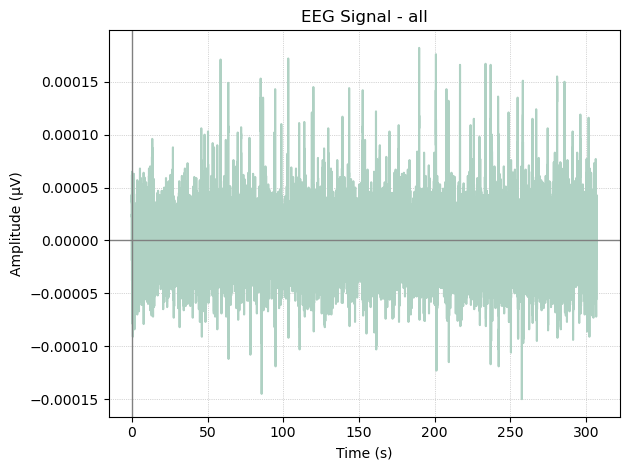

In [20]:
window_size = 100
plt.plot(df['time'], df[channel],color='#afd1c3')
plt.title(f"EEG Signal - {channel}")


plt.axvline(x=0, color='gray', linestyle='solid', linewidth=1)

# add horizontal line
plt.axhline(y=0, color='gray', linestyle='solid', linewidth=1)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV)")
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

# Filtering


to filter the data, usually, DFT is followed by some filtering process, then the inverse DFT is calculated

# Discrete Fourier Transformation


the inverse of the fourier transformation 
$$X_k = \sum^{N-1}_{n=0}x_n e^{  -2\pi i \frac{k n}{N}} \quad k = 0, 1, 2, \dots ,N - 1$$

is given by 

$$x_n = \frac{1}{N} \sum^{N-1}_{k=0}X_k e^{  2\pi i\frac{k n}{N}} \quad k = 1, 2, \dots ,N - 1$$

## Fourier Transformation

 takes time domain signals and decomposes it into a sum of sinusoidal components so the numerical prescence of frequency can be noted. Once the magnitude of a Fourier transformation is taken, we can see the general level at which oscillations are.

In [ ]:
def fft(x):
    N = len(x)
    if N <= 1:
        return x

    if N % 2 != 0:
        raise ValueError("Size of input must be a power of 2")

    even = fft(x[0::2])
    odd = fft(x[1::2])
    T = [cmath.exp(-2j * cmath.pi * k / N) * odd[k] for k in range(N // 2)]
    
    return [even[k] + T[k] for k in range(N // 2)] + \
           [even[k] - T[k] for k in range(N // 2)]


def ift(y):
    N = len(y)
    if N <= 1:
        return y
    
    if N % 2 != 0:
        raise ValueError("Size of input should be power of 2")
    
    even = ift(y[0::2])
    odd = ift(y[1::2])
    T = [cmath.exp(-2j * cmath.pi * k / N) * odd[k] for k in range(N//2)]

    return [even[k] + T[k] for k in range(N // 2)] + \
           [even[k] - T[k] for k in range(N // 2)]


In [ ]:
signal = df[channel].values
N = 2**int(np.ceil(np.log2(len(signal))))
x_padded = np.pad(signal, (0, N - len(signal)), 'constant')
dft_signal = fft(x_padded)
magnitude = np.abs(dft_signal) * 1000

# Compute frequency bins
dt = np.mean(np.diff(df['time']))  # Sampling interval
freqs = np.fft.fftfreq(N, d=dt)


Inverse Fourier Transformation

$$x_n =  \frac{1}{N}\sum^{N-1}_{k=0}X_k e^{ \frac{+2\pi i k n}{N}} \quad k = 1, 2, \dots ,N - 1$$

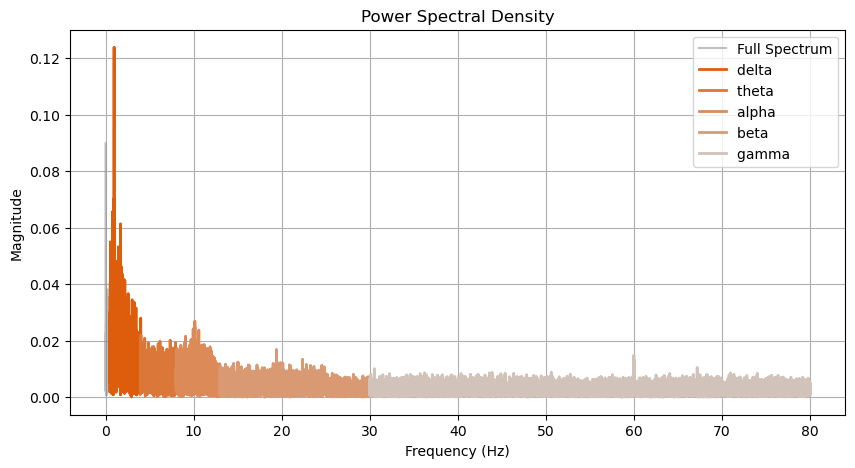

In [63]:
bands = {
    'delta': (0.5,4),
    'theta': (4,8),
    'alpha': (8,13),
    'beta': (13,30),
    'gamma': (30, 100)
}
colors = ['#de5d0d', '#db7739', '#db8a58', '#d99a73', "#d2c3ba"]

plt.figure(figsize=(10, 5))
plt.plot(freqs[:N//2], magnitude[:N//2], color='gray', alpha=0.5, label='Full Spectrum')

for i, (band, limits) in enumerate(bands.items()):
    mask = (freqs[:N//2] >= limits[0]) & (freqs[:N//2] < limits[1])
    band_freqs = freqs[:N//2][mask]
    band_mag = magnitude[:N//2][mask]
    if len(band_freqs) > 0:
        # Color by max value in region
        plt.plot(band_freqs, band_mag, color=colors[i], linewidth=2,
                 label=f"{band} ")
plt.title("Power Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
cutoff_hz = 90
sample_rate = 40


def ideal_low_pass(freqs, spectrum, cutoff_hz, sample_rate):
    filtered = spectrum.copy()
    N = len(freqs)
    for i, f in enumerate(freqs):
        if abs(f) > cutoff_hz:
            filtered[i] = 0
    return filtered

filtered = ideal_low_pass(freqs, dft_signal, cutoff_hz, sample_rate)
magnitude = np.abs(filtered)

# Apply filter

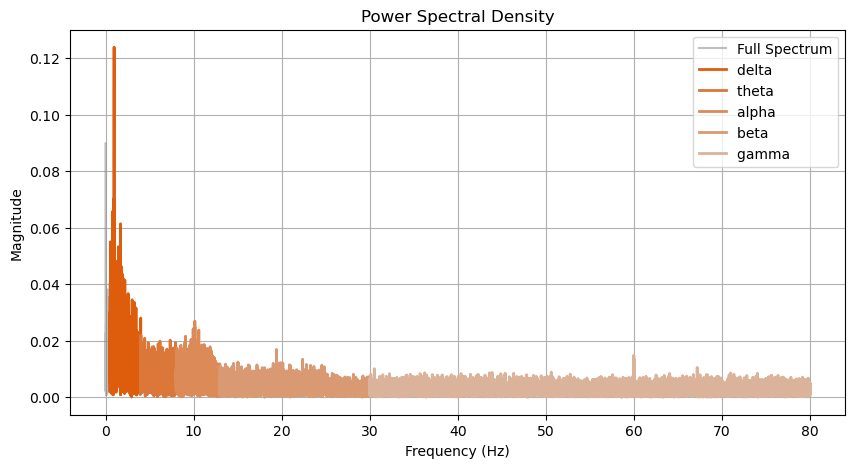

In [62]:
bands = {
    'delta': (0.5,4),
    'theta': (4,8),
    'alpha': (8,13),
    'beta': (13,30),
    'gamma': (30, 100)
}
colors = ['#de5d0d', '#db7739', '#db8a58', '#d99a73', '#dbb39a']

plt.figure(figsize=(10, 5))
plt.plot(freqs[:N//2], magnitude[:N//2], color='gray', alpha=0.5, label='Full Spectrum')

for i, (band, limits) in enumerate(bands.items()):
    mask = (freqs[:N//2] >= limits[0]) & (freqs[:N//2] < limits[1])
    band_freqs = freqs[:N//2][mask]
    band_mag = magnitude[:N//2][mask]
    if len(band_freqs) > 0:
        # Color by max value in region
        plt.plot(band_freqs, band_mag, color=colors[i], linewidth=2,
                 label=f"{band} ")
plt.title("Power Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True)
plt.show()


/var/folders/p9/n04hcd657r93rwljz4zpmh1w0000gn/T/ipykernel_15242/1377038126.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


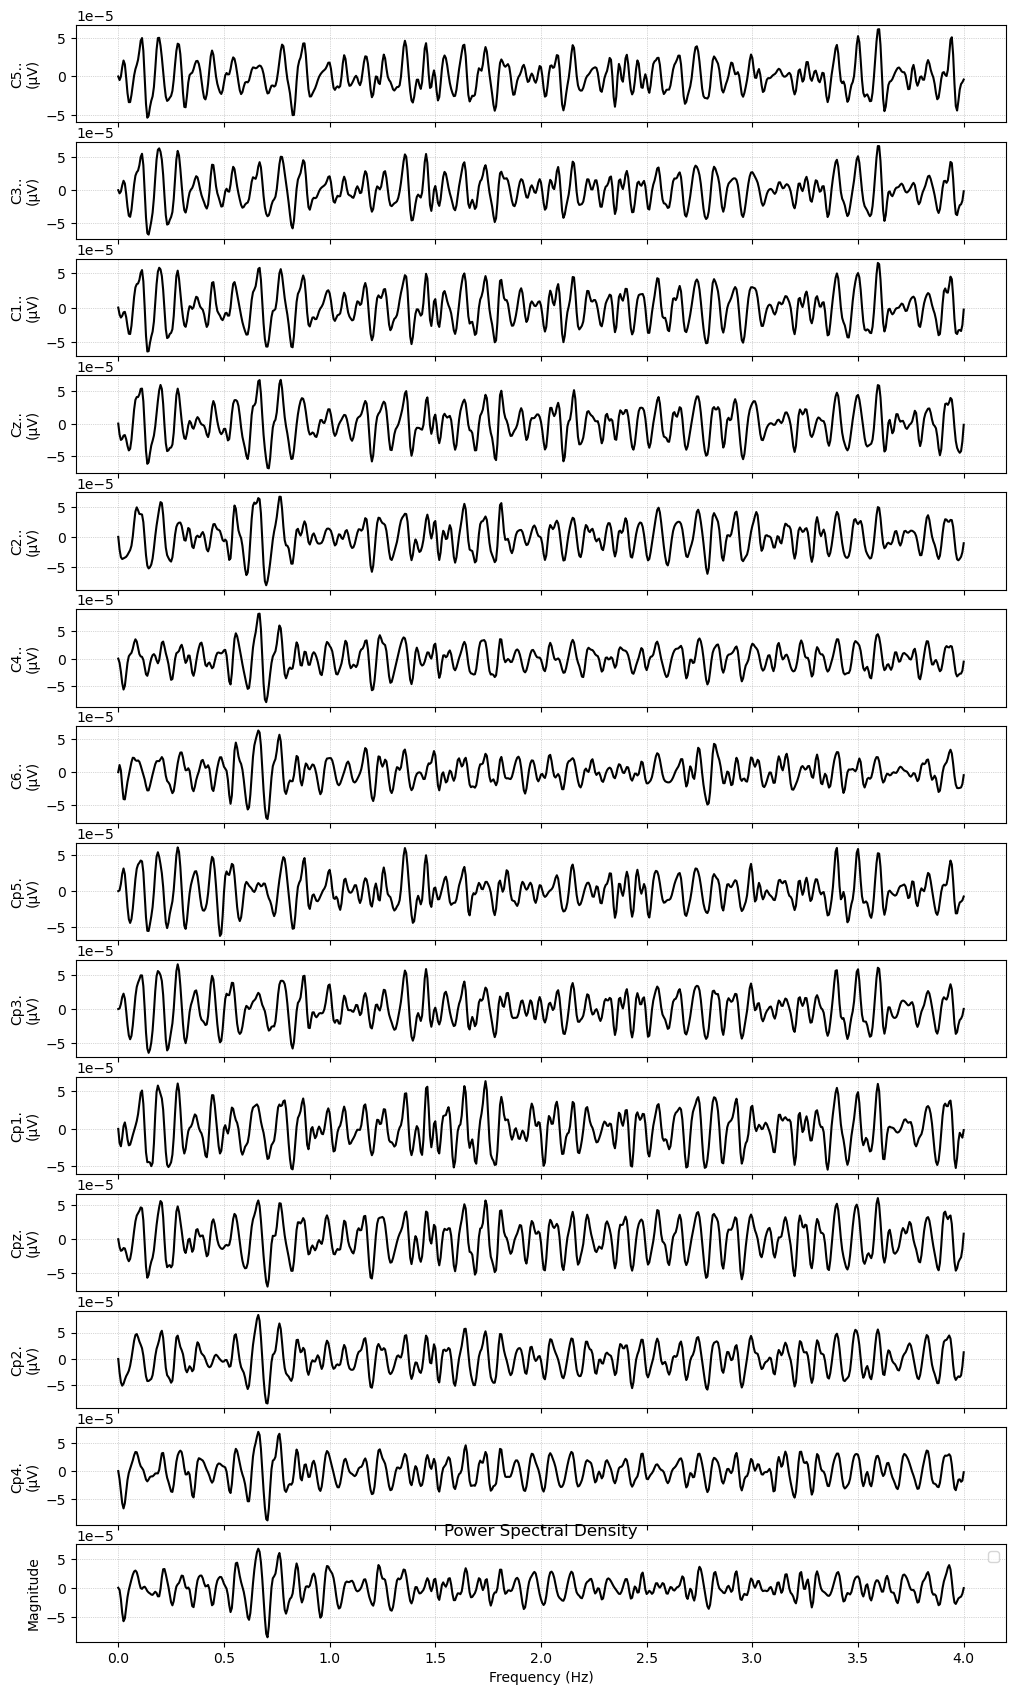

<Figure size 640x480 with 0 Axes>

In [ ]:

channel_names = epochs.ch_names
c_region_indices = [i for i, name in enumerate(channel_names) if name.startswith('C')]
c_region_names = [channel_names[i] for i in c_region_indices]
n_c_channels = len(c_region_indices)

fig, axs = plt.subplots(n_c_channels, 1, figsize=(12, n_c_channels * 1.5), sharex=True)
for idx, ch_idx in enumerate(c_region_indices):
    plt.title("Power Spectral Density")  
    axs[idx].plot(np.linspace(0, 4, X.shape[2]), X[0, ch_idx, :], color='black')
    axs[idx].set_ylabel(f"{c_region_names[idx]}\n(μV)")
    axs[idx].grid(True, linestyle=':', linewidth=0.5)
    

plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True)
plt.show()


axs[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()


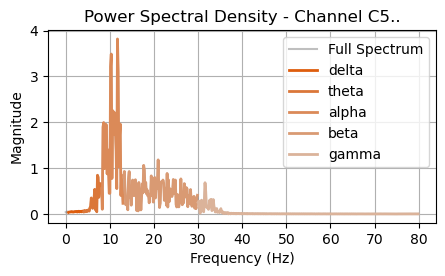

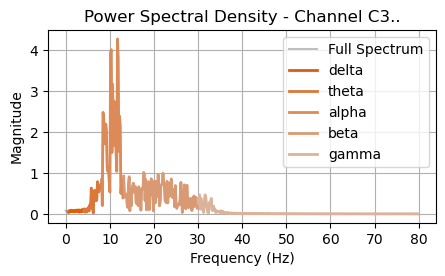

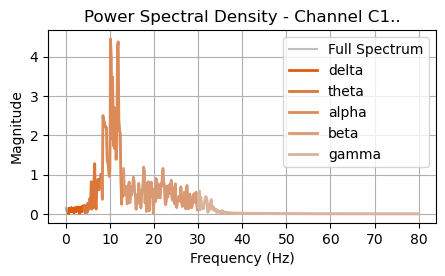

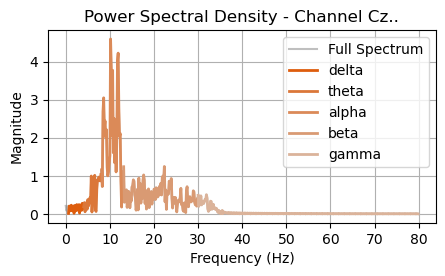

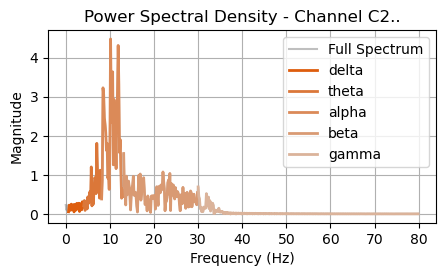

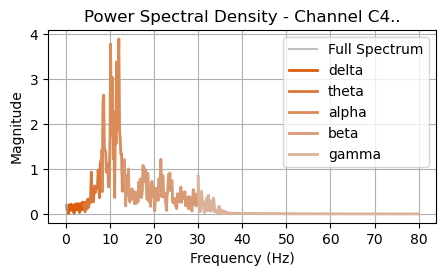

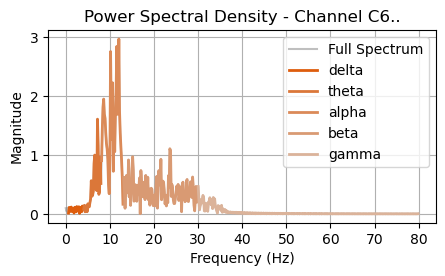

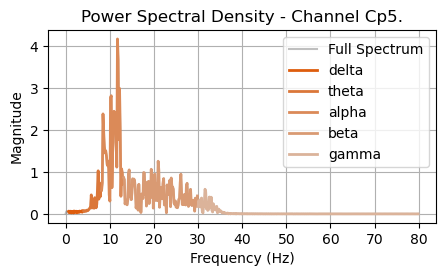

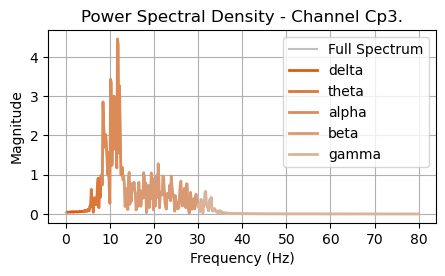

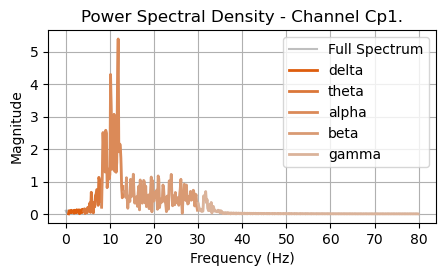

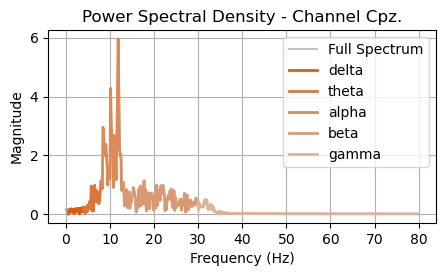

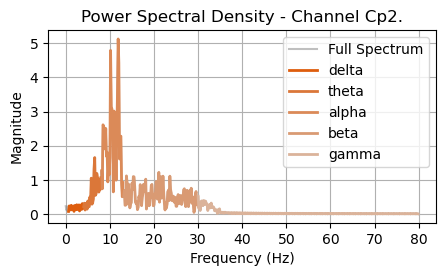

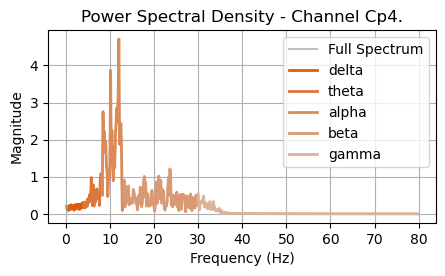

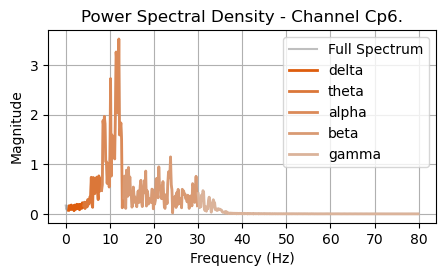

In [ ]:
# Define frequency bands
bands = {
    'delta': [0.5, 4],
    'theta': [4, 8],
    'alpha': [8, 13],
    'beta': [13, 30],
    'gamma': [30, 80]
}
colors = ['#de5d0d', '#db7739', '#db8a58', '#d99a73', '#dbb39a']

for idx, ch_idx in enumerate(c_region_indices):
    signal_channel = X[0, ch_idx, :]  
    N_2 = 2**int(np.ceil(np.log2(len(signal_channel))))
    padded_signal = np.pad(signal_channel, (0, N_2 - len(signal_channel)), 'constant')
    dft_per_channel = fft(padded_signal)
    magnitude_channel = np.abs(dft_per_channel) * 1000

    # Compute frequency bins
    dt = np.mean(np.diff(df['time']))  # Sampling interval
    freqs_channel = np.fft.fftfreq(N_2, d=dt)

    plt.figure(figsize=(5, 2.5))
    plt.plot(freqs_channel[:N_2//2], magnitude_channel[:N_2//2], color='gray', alpha=0.5, label='Full Spectrum')

    for i, (band, limits) in enumerate(bands.items()):
        mask = (freqs_channel[:N_2//2] >= limits[0]) & (freqs_channel[:N_2//2] < limits[1])
        band_freqs = freqs_channel[:N_2//2][mask]
        band_mag = magnitude_channel[:N_2//2][mask]
        if len(band_freqs) > 0:
            plt.plot(band_freqs, band_mag, color=colors[i], linewidth=2,
                     label=f"{band}")
    plt.title(f"Power Spectral Density - Channel {c_region_names[idx]}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid(True)
    plt.show()



# Notes 


Modeling Confusion - which areas of the brain are most prominent in detecting a person's reading capability